In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from nba_api.stats.endpoints import shotchartdetail

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
# =============================================================================
# 1. DATA IMPORT AND PROCESSING
# =============================================================================

# Load Curry data (your existing code)
seasons = ['2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']

def find_player(player_id):
    shots_df = None
    for season in seasons:
        shots = shotchartdetail.ShotChartDetail(
            team_id=0,
            player_id=player_id,  
            season_type_all_star='Regular Season',
            context_measure_simple='FGA',
            season_nullable=season
        ).get_data_frames()[0]
        shots['SEASON'] = season
        if shots_df is None:
            shots_df = shots
        else:
            shots_df = pd.concat([shots_df, shots], ignore_index=True)
    return shots_df

# Get Curry data
curry = find_player(201939)
df = curry[['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 
           'LOC_X','LOC_Y', 'SHOT_MADE_FLAG', 'HTM', 'VTM']].copy()

# Process data
df['Time_remaining'] = df['MINUTES_REMAINING'] * 60 + df['SECONDS_REMAINING']
df['Opponent'] = np.where(df['HTM'] == 'GSW', df['VTM'], df['HTM'])
df['Home'] = np.where(df['HTM'] == 'GSW', 1, 0)
df = df.drop(columns=['MINUTES_REMAINING', 'HTM', 'VTM'])

# Import probability model and recreate the exact preprocessing pipeline
model = keras.models.load_model('best_neural_network_model.keras')
print("Loaded Keras model")

# Recreate the exact same preprocessing as during training
# This must match your training code exactly!

# Create the same one-hot encoded features
X_features = pd.get_dummies(df.drop(columns=['SHOT_MADE_FLAG', 'Opponent']), columns=['ACTION_TYPE'])
X_features = X_features.astype('float32')

print(f"Features shape: {X_features.shape}")
print(f"Model expects: {model.input_shape}")

# Ensure we have the same columns as training data
# You may need to handle missing ACTION_TYPE categories that were in training but not in this data
expected_features = 46  # Your model expects 46 features

if X_features.shape[1] != expected_features:
    print(f"Warning: Feature count mismatch. Got {X_features.shape[1]}, expected {expected_features}")
    print("You may need to save the feature names from training and ensure consistency")
    
    # For now, let's try with available features
    # In production, you'd need to save the column names from training
    if X_features.shape[1] < expected_features:
        # Pad with zeros for missing features
        missing_cols = expected_features - X_features.shape[1]
        padding = np.zeros((X_features.shape[0], missing_cols))
        X_features = np.column_stack([X_features, padding])
        print(f"Padded features to {X_features.shape[1]}")
    elif X_features.shape[1] > expected_features:
        # Trim excess features
        X_features = X_features.iloc[:, :expected_features]
        print(f"Trimmed features to {X_features.shape[1]}")

# Get shot probabilities from your trained model
shot_probs = model.predict(X_features, verbose=0)
df['shot_prob'] = shot_probs.flatten() if shot_probs.ndim > 1 else shot_probs

print(f"Loaded {len(df)} shots")
print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Loaded Keras model
Features shape: (8895, 46)
Model expects: (None, 46)
Loaded 8895 shots
Data shape: (8895, 10)
Columns: ['PERIOD', 'SECONDS_REMAINING', 'ACTION_TYPE', 'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG', 'Time_remaining', 'Opponent', 'Home', 'shot_prob']


In [8]:
# =============================================================================
# 2. STATES
# =============================================================================

# Environment and state management
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

def normalize_state(loc_x, loc_y, time_remaining, shot_clock, period, shot_prob, home=1):
    """Convert raw features to normalized state vector"""
    # Ensure shot_prob is a scalar value
    if hasattr(shot_prob, '__len__') and len(shot_prob) > 0:
        shot_prob = float(shot_prob[0])
    else:
        shot_prob = float(shot_prob)
        
    return np.array([
        loc_x / 250,  # Normalize court coordinates
        loc_y / 940,
        time_remaining / 720,  # Game time
        shot_clock / 24,
        period / 4,  # Quarter
        shot_prob,
        home  # Add home field to state
    ], dtype=np.float32)

def is_three_pointer(loc_x, loc_y):
    """Check if shot is from 3-point range"""
    distance = np.sqrt(loc_x**2 + loc_y**2)
    return distance > 237

def step_environment(state_dict, action):
    """
    Environment step function
    Actions: 0=SHOOT, 1=PASS, 2=MOVE
    Returns: (next_state_dict, reward, done)
    """
    reward = 0
    done = False
    next_state = state_dict.copy()
    
    if action == 0:  # SHOOT
        shot_made = np.random.random() < state_dict['shot_prob']
        shot_value = 3 if is_three_pointer(state_dict['loc_x'], state_dict['loc_y']) else 2
        reward = shot_value if shot_made else 0
        done = True
        
    elif action == 1:  # PASS
        if np.random.random() < 0.7:  # 70% successful pass
            reward = 0.1
            next_state['shot_clock'] -= np.random.uniform(2, 6)
            if next_state['shot_clock'] <= 0:
                reward = -0.5
                done = True
        else:
            reward = -1.0  # Turnover
            done = True
            
    elif action == 2:  # MOVE
        # Simulate movement
        move_x = np.random.uniform(-30, 30)
        move_y = np.random.uniform(-20, 40)
        
        next_state['loc_x'] = np.clip(next_state['loc_x'] + move_x, -250, 250)
        next_state['loc_y'] = np.clip(next_state['loc_y'] + move_y, -50, 940)
        
        # Update shot probability based on new location using your model
        # Create the same feature vector as during training
        new_row = pd.DataFrame({
            'PERIOD': [next_state['period']],
            'Time_remaining': [next_state['time_remaining']],
            'LOC_X': [next_state['loc_x']],
            'LOC_Y': [next_state['loc_y']],
            'Home': [state_dict.get('home', 1)],
            'ACTION_TYPE': ['Jump Shot']  # Default action type
        })
        
        # Apply same preprocessing as training
        new_X = pd.get_dummies(new_row, columns=['ACTION_TYPE'])
        new_X = new_X.astype('float32')
        
        # Ensure same number of features as training (pad/trim if needed)
        if new_X.shape[1] < expected_features:
            padding = np.zeros((1, expected_features - new_X.shape[1]))
            new_X = np.column_stack([new_X, padding])
        elif new_X.shape[1] > expected_features:
            new_X = new_X.iloc[:, :expected_features]
            
        next_state['shot_prob'] = float(model.predict(new_X, verbose=0)[0][0])
        
        next_state['shot_clock'] -= np.random.uniform(1, 3)
        reward = 0.05
        
        if next_state['shot_clock'] <= 0:
            reward = -0.5
            done = True
    
    return next_state, reward, done

In [9]:
# =============================================================================
# 3. INITIALIZE MODEL
# =============================================================================

# DQN Model architecture
state_size = 7  # Updated to include home field
action_size = 3  # SHOOT, PASS, MOVE
hidden_size = 128

q_network = keras.Sequential([
    layers.Input(shape=(state_size,)),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dense(action_size, activation='linear')
])

target_network = keras.Sequential([
    layers.Input(shape=(state_size,)),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dense(action_size, activation='linear')
])

# Compile models
learning_rate = 1e-3
q_network.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse')
target_network.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse')

# Initialize target network
target_network.set_weights(q_network.get_weights())

# Replay buffer
replay_buffer = deque(maxlen=100000)

print("Models initialized")
print(f"Q-Network summary:")
q_network.summary()

Models initialized
Q-Network summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,435 (134.51 KB)

 Trainable params: 34,435 (134.51 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# =============================================================================
# 4. TRAIN
# =============================================================================

# Training parameters (ULTRA FAST for testing)
episodes = 100  # Drastically reduced for testing
batch_size = 256  # Large batches
gamma = 0.99
epsilon = 0.5  # Start with less exploration
epsilon_min = 0.1
epsilon_decay = 0.95  # Very fast decay
target_update_freq = 20  # Very frequent updates

# Pre-compile model for faster predictions
dummy_input = np.zeros((1, state_size), dtype=np.float32)
q_network.predict(dummy_input, verbose=0)
target_network.predict(dummy_input, verbose=0)

# Tracking metrics
scores = []
losses = []
epsilons = []

print(f"\nStarting ULTRA FAST training for {episodes} episodes...")
print("This is a quick test - increase episodes later if it works!")

for episode in range(episodes):
    # Initialize episode
    data_row = df.sample(1).iloc[0]
    state_dict = {
        'loc_x': data_row['LOC_X'],
        'loc_y': data_row['LOC_Y'],
        'time_remaining': data_row['Time_remaining'],
        'shot_clock': 24.0,
        'period': data_row['PERIOD'],
        'shot_prob': data_row['shot_prob'],
        'home': data_row['Home']
    }
    
    state = normalize_state(**state_dict)
    total_reward = 0
    episode_loss = 0
    loss_count = 0
    steps = 0
    max_steps = 5  # Very short episodes
    
    # Episode loop
    while steps < max_steps:
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = random.randrange(action_size)
        else:
            state_batch = np.expand_dims(state, axis=0)
            q_values = q_network.predict(state_batch, verbose=0)
            action = np.argmax(q_values[0])
        
        # Take action
        next_state_dict, reward, done = step_environment(state_dict, action)
        next_state = normalize_state(**next_state_dict) if not done else None
        
        # Store experience
        experience = Experience(state, action, reward, next_state, done)
        replay_buffer.append(experience)
        
        # Train very infrequently
        if len(replay_buffer) >= batch_size and episode % 5 == 0:  # Only train every 5 episodes
            # Sample batch
            batch = random.sample(replay_buffer, batch_size)
            
            states = np.array([e.state for e in batch])
            actions = np.array([e.action for e in batch])
            rewards = np.array([e.reward for e in batch])
            next_states = np.array([e.next_state if e.next_state is not None 
                                   else np.zeros_like(e.state) for e in batch])
            dones = np.array([e.done for e in batch])
            
            # Current Q values
            current_q_values = q_network.predict(states, verbose=0)
            
            # Next Q values from target network
            next_q_values = target_network.predict(next_states, verbose=0)
            max_next_q_values = np.max(next_q_values, axis=1)
            
            # Calculate targets
            target_q_values = current_q_values.copy()
            for i in range(batch_size):
                if dones[i]:
                    target_q_values[i, actions[i]] = rewards[i]
                else:
                    target_q_values[i, actions[i]] = rewards[i] + gamma * max_next_q_values[i]
            
            # Train
            history = q_network.fit(states, target_q_values, batch_size=batch_size, 
                                   epochs=1, verbose=0)
            episode_loss += history.history['loss'][0]
            loss_count += 1
        
        total_reward += reward
        steps += 1
        
        if done:
            break
        
        # Update state
        state_dict = next_state_dict
        state = next_state
    
    # Update target network
    if episode % target_update_freq == 0:
        target_network.set_weights(q_network.get_weights())
    
    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    
    # Record metrics
    scores.append(total_reward)
    losses.append(episode_loss / max(1, loss_count))
    epsilons.append(epsilon)
    
    # Print progress frequently
    if episode % 20 == 0:  # Every 20 episodes
        avg_score = np.mean(scores[-10:]) if len(scores) >= 10 else np.mean(scores)
        print(f"Episode {episode:3d} | Score: {avg_score:5.2f} | Epsilon: {epsilon:.2f}")

print("Quick training completed! If this worked, increase episodes for real training.")



Starting ULTRA FAST training for 100 episodes...
This is a quick test - increase episodes later if it works!
Episode   0 | Score:  3.00 | Epsilon: 0.47
Episode  20 | Score:  1.05 | Epsilon: 0.17
Episode  40 | Score:  1.12 | Epsilon: 0.10
Episode  60 | Score:  0.99 | Epsilon: 0.10
Episode  80 | Score:  0.60 | Epsilon: 0.10
Quick training completed! If this worked, increase episodes for real training.


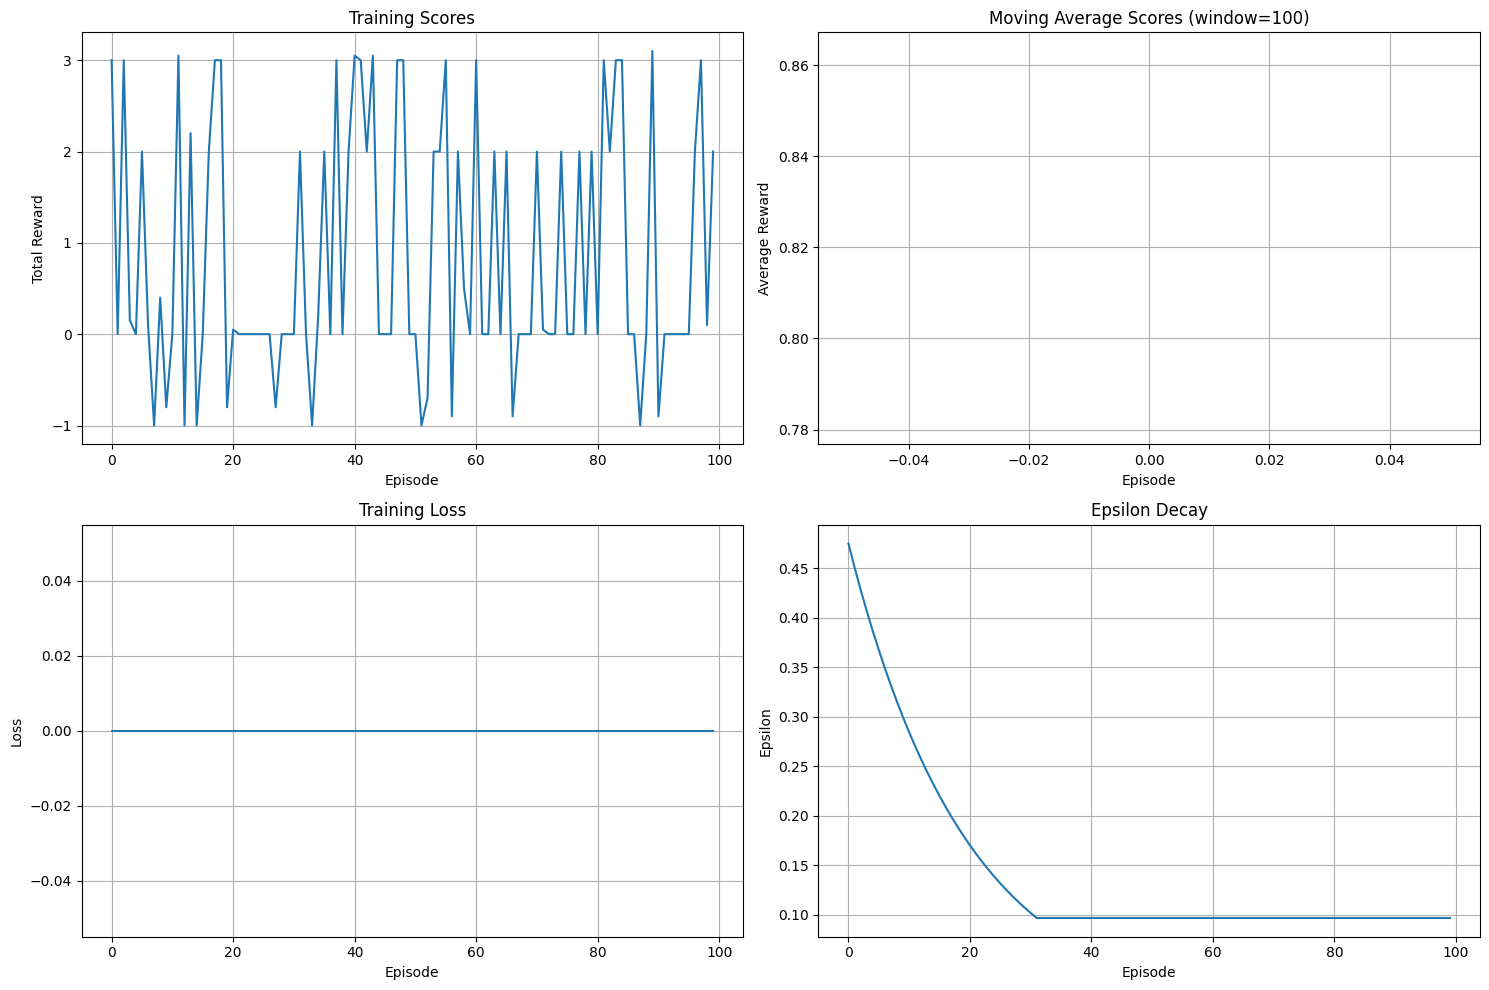


Evaluating final policy...
Average reward: 0.884
Standard deviation: 1.363
Action distribution:
  SHOOT: 865 (65.8%)
  PASS:  448 (34.1%)
  MOVE:  2 (0.2%)


In [11]:
# =============================================================================
# 5. DISPLAY RESULTS
# =============================================================================

# Plot training results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scores
axes[0, 0].plot(scores)
axes[0, 0].set_title('Training Scores')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].grid(True)

# Moving average scores
window = 100
if len(scores) >= window:
    moving_avg = [np.mean(scores[i:i+window]) for i in range(len(scores)-window+1)]
    axes[0, 1].plot(moving_avg)
    axes[0, 1].set_title(f'Moving Average Scores (window={window})')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Average Reward')
    axes[0, 1].grid(True)

# Losses
axes[1, 0].plot(losses)
axes[1, 0].set_title('Training Loss')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True)

# Epsilon decay
axes[1, 1].plot(epsilons)
axes[1, 1].set_title('Epsilon Decay')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Epsilon')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Evaluate final policy
print("\nEvaluating final policy...")
total_rewards = []
action_counts = {0: 0, 1: 0, 2: 0}  # SHOOT, PASS, MOVE

for _ in range(1000):
    data_row = df.sample(1).iloc[0]
    state_dict = {
        'loc_x': data_row['LOC_X'],
        'loc_y': data_row['LOC_Y'],
        'time_remaining': data_row['Time_remaining'],
        'shot_clock': 24.0,
        'period': data_row['PERIOD'],
        'shot_prob': data_row['shot_prob'],
        'home': data_row['Home']
    }
    
    state = normalize_state(**state_dict)
    total_reward = 0
    steps = 0
    
    while steps < 50:
        # Greedy action selection
        state_batch = np.expand_dims(state, axis=0)
        q_values = q_network.predict(state_batch, verbose=0)
        action = np.argmax(q_values[0])
        action_counts[action] += 1
        
        next_state_dict, reward, done = step_environment(state_dict, action)
        total_reward += reward
        steps += 1
        
        if done:
            break
        
        state_dict = next_state_dict
        state = normalize_state(**state_dict)
    
    total_rewards.append(total_reward)

# Print evaluation results
print(f"Average reward: {np.mean(total_rewards):.3f}")
print(f"Standard deviation: {np.std(total_rewards):.3f}")
print(f"Action distribution:")
print(f"  SHOOT: {action_counts[0]} ({action_counts[0]/sum(action_counts.values())*100:.1f}%)")
print(f"  PASS:  {action_counts[1]} ({action_counts[1]/sum(action_counts.values())*100:.1f}%)")
print(f"  MOVE:  {action_counts[2]} ({action_counts[2]/sum(action_counts.values())*100:.1f}%)")